In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

**Part 1: Import Data and Preprocess**



In [ ]:
#Read data in
raw_data=pd.read_csv("https://raw.githubusercontent.com/sudhijag/test/master/BTC-USD.csv", header= None)
raw_data.columns=["time", "low","high","open","close", "volume"]
raw_data=raw_data.drop(["time", "low", "high"], axis=1)

#Scale data
scaler=MinMaxScaler()
raw_data= scaler.fit_transform(raw_data)
raw_data= pd.DataFrame(raw_data)
raw_data.columns=["open", "close","volume"]
print(raw_data)

           open     close    volume
0      0.262087  0.263039  0.000730
1      0.262084  0.262237  0.009613
2      0.261277  0.259290  0.003851
3      0.258333  0.259290  0.001750
4      0.258330  0.259501  0.000937
...         ...       ...       ...
97719  0.344806  0.345707  0.000958
97720  0.345547  0.346217  0.001249
97721  0.345369  0.346217  0.001273
97722  0.345369  0.346395  0.004546
97723  0.345543  0.346395  0.000638

[97724 rows x 3 columns]


In [ ]:
#Split into training and testing
boundary= int(0.8*len(raw_data))
training_data = raw_data.iloc[:boundary,:]
testing_data = raw_data.iloc[boundary:,:]

print(training_data.tail())
print(testing_data.head())

           open     close    volume
78174  0.185514  0.187012  0.002468
78175  0.185958  0.187386  0.001428
78176  0.186336  0.187386  0.002401
78177  0.186336  0.188121  0.002493
78178  0.187065  0.187389  0.001671
           open     close    volume
78179  0.186340  0.187522  0.001927
78180  0.186473  0.188121  0.000463
78181  0.187069  0.189785  0.004435
78182  0.188738  0.189785  0.001807
78183  0.188738  0.188909  0.005114


In [ ]:
X_sequence= []
y_sequence= []
frame_size= 3
training_data= np.array(training_data)

y_temp=training_data[:,0]
for i in range(frame_size, len(training_data)):
  X_sequence.append(training_data[i-frame_size:i, :])
  y_sequence.append(y_temp[i]) 

In [ ]:
print(type(X_sequence))

X_sequence= np.array(X_sequence)
y_sequence= np.array(y_sequence)
print(X_sequence.shape)
y_sequence.shape

<class 'list'>
(78176, 3, 3)


(78176,)

**Part 2: Making the Model**

In [ ]:
#leaving activation blank activates CuDNN?
RNN= Sequential(
  [
    LSTM(name="LSTM_LAYER_1",units=128, return_sequences=True, input_shape= (frame_size, len(raw_data.columns))),
    Dropout(0.50),

    LSTM(name="LSTM_LAYER_2",units=128, return_sequences=True),
    Dropout(0.50),

    LSTM(name="LSTM_LAYER_3", return_sequences=True, units=128),
    Dropout(0.50),

    LSTM(name="LSTM_LAYER_4", units=256),
    Dropout(0.50),

    Dense(units=1)
  ]
)

In [ ]:
RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_LAYER_1 (LSTM)          (None, 3, 128)            67584     
_________________________________________________________________
dropout (Dropout)            (None, 3, 128)            0         
_________________________________________________________________
LSTM_LAYER_2 (LSTM)          (None, 3, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
LSTM_LAYER_3 (LSTM)          (None, 3, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
LSTM_LAYER_4 (LSTM)          (None, 256)               3

In [ ]:
RNN.compile(optimizer="adam", loss= 'mse')

In [ ]:
RNN.fit(X_sequence, y_sequence, epochs=2, batch_size=32)

Epoch 1/2
2443/2443 [==============================] - 14s 6ms/step - loss: 0.0026
Epoch 2/2
2443/2443 [==============================] - 14s 6ms/step - loss: 9.6879e-04


**Part 3: Predicting on Test Data**

In [ ]:
X_sequence_test= []
y_sequence_test=[]
testing_data=np.array(testing_data)
testing_y=testing_data[:,0]

for i in range(frame_size, len(testing_data)):
  X_sequence_test.append(testing_data[i-frame_size:i])
  y_sequence_test.append(testing_y[i])

In [ ]:
print(type(X_sequence_test))

X_sequence_test= np.array(X_sequence_test)
y_sequence_test= np.array(y_sequence_test)

print(X_sequence_test.shape)
print(y_sequence_test.shape)

<class 'list'>
(19542, 3, 3)
(19542,)


In [ ]:
predictions= RNN.predict(X_sequence_test)
rescaled_predictions = predictions* scaler.scale_[0]
actual= testing_y * scaler.scale_[0]

**Part 4: Plotting**

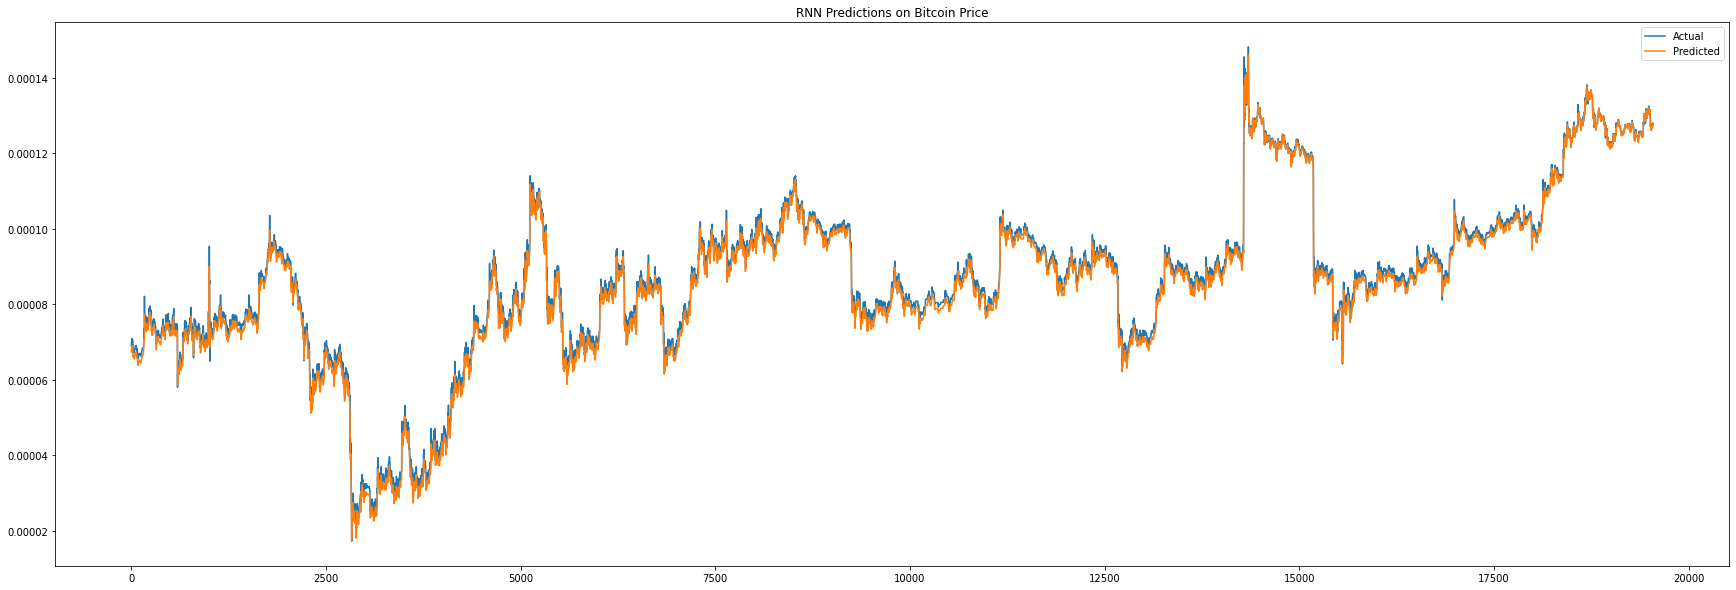

In [ ]:
plt.figure(figsize=(30,10))
plt.title("RNN Predictions on Bitcoin Price")
plt.plot(actual, label= "Actual")
plt.plot(rescaled_predictions, label ="Predicted")
plt.legend()
plt.show()

In [ ]:
"""
flattened= predictions.flatten()

flattened=flattened[frame_size:]
print("flattened" , flattened.shape)
print("testing_y", testing_y.shape)

mse = np.mean((flattened - testing_y)**2)
print(mse)
"""

'\nflattened= predictions.flatten()\n\nflattened=flattened[frame_size:]\nprint("flattened" , flattened.shape)\nprint("testing_y", testing_y.shape)\n\nmse = np.mean((flattened - testing_y)**2)\nprint(mse)\n'